In [1]:
import os
import math
import napari
import tifffile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy
from skimage import io, data
import bigfish.stack as stack
from bigfish.multistack import match_nuc_cell
import tkinter as tk
from tkinter import filedialog

from cellpose import models
from cellpose.utils import remove_edge_masks
from cellpose.io import imread, save_to_png, masks_flows_to_seg

In [2]:
from cropFunctions import *

In [3]:
def groupSequence(lst):
    res = [[lst[0]]]
 
    for i in range(1, len(lst)):
        if lst[i-1]+1 == lst[i]:
            res[-1].append(lst[i])
 
        else:
            res.append([lst[i]])
    return res

In [4]:
def creatSummary(homeFolder, nameKey, MaxTimePoint):
    df = pd.DataFrame(columns=['Movie_Name','Total_cells', 'Incomplete', 'corrected', 'Final_number'])
    df.to_csv(homeFolder+'/missingDataSummary.csv')
    for i in next(os.walk(homeFolder))[1]:
        if nameKey in i:
            folderNames = os.listdir(os.path.join(homeFolder,i))
            cellFolderNames = [k for k in folderNames if 'cell_' in k]
            incomplete = 0
            corrected = 0
            for j in cellFolderNames:
                framesFound = len(os.listdir(os.path.join(homeFolder, i, j)))
                if framesFound<MaxTimePoint-missingFramesTol:
                    incomplete+=1
                elif framesFound >= MaxTimePoint-missingFramesTol and framesFound!=MaxTimePoint:
                    corrected+=1
            df2 = pd.DataFrame(np.array([i, len(cellFolderNames), incomplete, corrected,  len(cellFolderNames)-incomplete]).reshape(1,5), columns=['Movie_Name','Total_cells', 'Incomplete', 'corrected', 'Final_number'])
            df = pd.concat([df,df2])
            df = df.sort_values(by=['Movie_Name'])
    df.to_csv(homeFolder+'/missingDataSummary.csv')    

In [5]:
def choose_home_folder():
    root = tk.Tk()
    root.withdraw()  # Hide the main window

    file_path = filedialog.askdirectory(initialdir= "/", title='Please select a directory')  # Open file dialog

    root.destroy()  # Close the tkinter window
    return file_path

def get_session_name():
    root = tk.Tk()
    root.withdraw()  # Hide the main window

    file_path = filedialog.askopenfile(initialdir= "/", title='Please select movie file')  # Open file dialog

    root.destroy()  # Close the tkinter window
    return file_path

def get_model():
    root = tk.Tk()
    root.withdraw()  # Hide the main window

    file_path = filedialog.askopenfilename(initialdir= "/", title='Please select a movie')  # Open file dialog

    root.destroy()  # Close the tkinter window
    return file_path

In [6]:
homeFolder = choose_home_folder()
if np.size(list(homeFolder))!=0:
    sessionNames = [i for i in os.listdir(homeFolder) if '_F' in i and os.path.isdir(os.path.join(homeFolder,i))]
sessionNames.sort()


In [7]:
sessionNames

['Hela_h9_h2_k11_mcpsg_1hrbasal_14hr_TNF_TSA_exp2_2_F06']

In [8]:
dfCorrected = pd.DataFrame(columns=['imsq', 'cell_number', 'frames'])

In [9]:
identifier = 'cell_'
fidentifier = '_F'

In [10]:
if os.path.isfile(homeFolder+'/missingDataSummary.csv'):
    print('Check if summary already exist!! File will be overwritten!! This step has probably already been performed!!!')
    input('Do you still want to proceed?? y/n')

In [11]:
nameKey = sessionNames[0].split(fidentifier)[0]
MaxTimePoint = len([i for i in os.listdir(os.path.join(homeFolder,sessionNames[0])) if identifier not in i and 'background' not in i and 'intensities' not in i and 'LabelDF' not in i])
missingFramesTol = int(np.round(0.02*MaxTimePoint))
MaxTimePoint=899

In [12]:
if not os.path.isfile(homeFolder+'/missingDataSummary.csv'):
    print('file not found\nSummary will be created')
    creatSummary(homeFolder, nameKey, MaxTimePoint)
creatSummary(homeFolder, nameKey, MaxTimePoint)

file not found
Summary will be created


In [13]:
MaxTimePoint

899

Hela_h9_h2_k11_mcpsg_1hrbasal_14hr_TNF_TSA_exp2_2_F06
Frames Threshold : 881
C:/Users/uid-1204/Desktop/test2_bigFISHLIVE\tProjections\T_MAX_Hela_h9_h2_k11_mcpsg_1hrbasal_14hr_TNF_TSA_exp2_2_F06_cp_masks.png
['10', '11', '18', '5']
imsQ 06
Total cells =  18
incomplete cells =  3
corrected cells =  4
Checking cell number  10
['894', '841', '895', '826', '893']
[826, 841, 893, 894, 895]
cell number 10
total frames corrected =  5
ones  [826, 841]
middle  [[893, 894, 895]]
[893, 894, 895]
893
894
895
Last  []
imsQ 06
Total cells =  18
incomplete cells =  3
corrected cells =  3
Checking cell number  11
['827', '821', '825', '835', '832', '828', '856', '853', '830', '833', '829']
[821, 825, 827, 828, 829, 830, 832, 833, 835, 853, 856]
cell number 11
total frames corrected =  11
ones  [821, 825, 835, 853, 856]
middle  [[827, 828, 829, 830], [832, 833]]
[827, 828, 829, 830]
827
828
829
830
[832, 833]
832
833
Last  []
imsQ 06
Total cells =  18
incomplete cells =  3
corrected cells =  2
Checking 

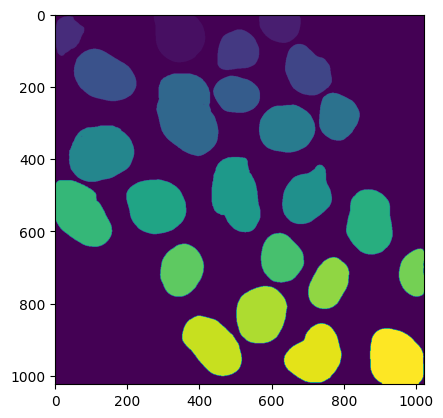

In [14]:
for sessionName in sessionNames:
    print(sessionName)
    skipped=[]
    imsQ = sessionName.split(fidentifier)[-1]
    nameKey = sessionName.split(fidentifier)[0]+fidentifier+imsQ
    imageName = nameKey
    pathToTimeFrames = os.path.join(homeFolder,sessionName,'*.tif')
    movieFolder = os.path.join(homeFolder,nameKey)


    extensionF = '.tif'
    print('Frames Threshold :',MaxTimePoint-missingFramesTol)

    maskFolder = os.path.join(homeFolder,'tProjections')
    maskpath = os.path.join(maskFolder,'T_MAX_'+imageName.replace('.','_')+'_cp_masks.png')
    print(maskpath)
    maskImageAll = imread(maskpath)
    plt.imshow(maskImageAll)
    cellNumbersFound = []
    for i in next(os.walk(movieFolder))[1]:
        if "cell_" in i:
            if (len(os.listdir(os.path.join(movieFolder,i))) >= MaxTimePoint-missingFramesTol) and len(os.listdir(os.path.join(movieFolder,i)))<MaxTimePoint:
                cellNumbersFound.append(i.split('cell_')[1])
    print(cellNumbersFound)

    ## Find missing frames

    while len(cellNumbersFound)!=0:
        totalCells = len([i for i in next(os.walk(movieFolder))[1] if "cell" in i])
        incompleteCells = len([i for i in next(os.walk(movieFolder))[1] if "cell" in i and (len(os.listdir(os.path.join(movieFolder,i))) < MaxTimePoint-missingFramesTol)])
        correctedCells = len(cellNumbersFound)

        print('imsQ', imsQ)
        print('Total cells = ', totalCells)
        print('incomplete cells = ', incompleteCells)
        print('corrected cells = ', correctedCells)

        if len(cellNumbersFound)!=0:
            cellNumber = cellNumbersFound[0]
            print('Checking cell number ', cellNumber)
            path_input = os.path.join(homeFolder,nameKey,'cell_'+str(cellNumber))
            nucleiStackForm = nameKey+"_cell_"
            labeldf = pd.read_pickle(os.path.join(movieFolder,"LabelDF.pkl")) 



        timep = np.arange(MaxTimePoint)
        timestr = [str(f"{i:03}") for i in timep]

        timePointsFound = [i.split('.')[0].split('_t')[-1] for i in os.listdir(path_input)]
        timePointsFound.sort()

        missingframes = list(set(timestr)-set(timePointsFound))
        print(missingframes)

        missingframesIdxs =  [timestr.index(missingframes[i]) for i in range(len(missingframes))]

        missingframesIdxs.sort()
        print(missingframesIdxs)
        print('cell number', cellNumber)
        print('total frames corrected = ', len(missingframesIdxs))

        grps = groupSequence(missingframesIdxs)
        grpsOnes = [grps[i][0] for i in range(len(grps)) if len(grps[i])==1 and grps[i][-1]!=MaxTimePoint-1 and grps[i][0]!=0]
        grpsMiddles = [grps[i] for i in range(len(grps)) if len(grps[i])>1 and grps[i][-1]!=MaxTimePoint-1 and grps[i][0]!=0]
        grpLast = [grps[i] for i in range(len(grps)) if len(grps[i])>=1 and grps[i][-1]==MaxTimePoint-1]
        grpFirst = [grps[i] for i in range(len(grps)) if len(grps[i])>=1 and grps[i][0]==0]

        print('ones ', grpsOnes)
        if len(grpsOnes)!=0:
            newmissingframesIdxs = grpsOnes #[missingframesIdxs[i] for i in seqsidx]
        #     print(newmissingframesIdxs)
            for jj in newmissingframesIdxs:
                tdx1 = jj-1
                tdx2 = jj+1        
                image1 = io.imread(os.path.join(path_input, nucleiStackForm+str(cellNumber)+'_t'+str(f"{tdx1:03}")+extensionF))
                image2 = io.imread(os.path.join(path_input, nucleiStackForm+str(cellNumber)+'_t'+str(f"{tdx2:03}")+extensionF))
                if image1.shape==image2.shape:
                    newimage = np.mean([image1,image2], axis=0).astype(np.uint16)
                    cellFileName = os.path.join(path_input, nucleiStackForm+str(cellNumber)+'_t'+str(f"{jj:03}")+extensionF)
                    with tifffile.TiffWriter(cellFileName, imagej=True) as tif:
                        tif.write(newimage)
                else:
                    print('skipping ', jj)
                    if cellNumber in cellNumbersFound:
                        cellNumbersFound.remove(cellNumber)
                        skipped.append(cellNumber)
                        #------------------------------------------------------------------------------# middle frames
        print('middle ',grpsMiddles)
        if len(grpsMiddles)!=0:
            for missingGroupsMiddle in grpsMiddles:
                print(missingGroupsMiddle)        
                tdx1 = missingGroupsMiddle[0]-1
                tdx2 = missingGroupsMiddle[-1]+1
                image1 = io.imread(os.path.join(path_input, nucleiStackForm+str(cellNumber)+'_t'+str(f"{tdx1:03}")+extensionF))
                image2 = io.imread(os.path.join(path_input, nucleiStackForm+str(cellNumber)+'_t'+str(f"{tdx2:03}")+extensionF))
                if image1.shape==image2.shape:
                    newimage = np.mean([image1,image2], axis=0).astype(np.uint16)
                    for i in missingGroupsMiddle:
                        print(i)
                        cellFileName = os.path.join(path_input, nucleiStackForm+str(cellNumber)+'_t'+str(f"{i:03}")+extensionF)
                        with tifffile.TiffWriter(cellFileName, imagej=True) as tif:
                            tif.write(newimage)
                else:
                    print('skipping ', jj)
                    if cellNumber in cellNumbersFound:
                        cellNumbersFound.remove(cellNumber)
                        skipped.append(cellNumber)
#------------------------------------------------------------------------------# Last frames'
        print('Last ',grpLast)
        if len(grpLast)!=0:    
            tdx1 = grpLast[0][0]-1
            newimage = io.imread(os.path.join(path_input, nucleiStackForm+str(cellNumber)+'_t'+str(f"{tdx1:03}")+extensionF))
            for i in missingframesIdxs:
                cellFileName = os.path.join(path_input, nucleiStackForm+str(cellNumber)+'_t'+str(f"{i:03}")+extensionF)
                with tifffile.TiffWriter(cellFileName, imagej=True) as tif:
                    tif.write(newimage)
                #------------------------------------------------------------------------------print('First ',grpFirst)
        if len(grpFirst)!=0:
            tdx1 = grpFirst[0][-1]+1
            newimage = io.imread(os.path.join(path_input, nucleiStackForm+str(cellNumber)+'_t'+str(f"{tdx1:03}")+extensionF))
            for i in grpFirst[0]:
                cellFileName = os.path.join(path_input, nucleiStackForm+str(cellNumber)+'_t'+str(f"{i:03}")+extensionF)
                with tifffile.TiffWriter(cellFileName, imagej=True) as tif:
                    tif.write(newimage)
                    #------------------------------------------------------------------------------
        df2 = pd.DataFrame(np.array([imsQ, cellNumber, str(missingframes)]).reshape(1,3), columns=['imsq', 'cell_number', 'frames'])
        dfCorrected = pd.concat([dfCorrected, df2])

        cellNumbersFound = []
        for i in next(os.walk(movieFolder))[1]:
            if "cell_" in i:
                if (len(os.listdir(os.path.join(movieFolder,i))) >= MaxTimePoint-missingFramesTol) and len(os.listdir(os.path.join(movieFolder,i)))<MaxTimePoint:
                    cellNumbersFound.append(i.split('cell_')[1])
        for ff in skipped:
            if ff in cellNumbersFound:
                cellNumbersFound.remove(ff)

dfCorrected.to_csv(os.path.join(homeFolder,'missingDataAddedFrames.csv'))